# SARIMA Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

### Why SARIMA?

During exploratory data analysis (EDA), we identified:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components,
- **Seasonal effects**, such as daily cyclic behavior.

This notebook walks through the full modeling pipeline using SARIMA.


In [1]:
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, SlidingWindowSplitter, temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sktime.forecasting.model_evaluation import evaluate
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

We begin by loading the preprocessed dataset specifically prepared for SARIMA and HWES models.


In [2]:
df = pd.read_parquet('../data/processed/preprocessed_sarima_15min.parquet')

df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Autocorrelation, Partial Autocorrelation Analysis and Stationarity Check (ADF Test)

To determine the appropriate AR (autoregressive) and MA (moving average) orders, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the target variable. Before fitting a SARIMA model, we need to verify if the time series is **stationary** — a key assumption for ARIMA-family models. We use the **Augmented Dickey-Fuller (ADF) test**, which tests the null hypothesis that the time series has a unit root (i.e., is non-stationary).

(3968,)

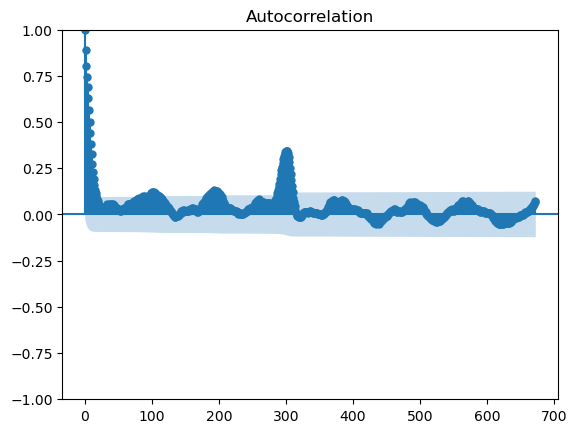

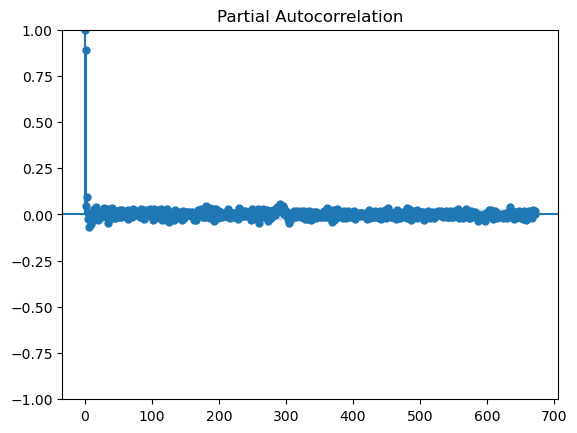

In [3]:
y = df["recommended_fee_fastestFee"]
plot_acf(y, lags=96*7)   
plot_pacf(y, lags=96*7)
y.shape


In [4]:
adfuller(y)[1]

np.float64(2.8563716542205644e-20)

The PACF cuts off at lag 1 and the ACF shows a significant lag-1 with slow decay, suggesting an ARIMA(1, 0, 1) structure. Clear seasonal spikes at lag 96 in the ACF indicate a seasonal pattern, so we set the seasonal order to (1, 0, 1, 96)

## 3. Train-Test Splits using Expanding and Sliding Window

### 3.1.1 Expanding Window Forecasting - Daily (optional)

Use expanding window to evaluate SARIMA performance across different time periods (7-day initial window, 1-day forecast).

In [5]:
# warnings.filterwarnings("ignore", category=FutureWarning)

# # Define forecast horizon: next 96 steps (15min × 96 = 1 day)
# fh = list(range(1, 97))

# # Create expanding window splitter
# expanding_cv = ExpandingWindowSplitter(
#     initial_window=96 * 7,   # 1 week of training data
#     step_length=96,          # move window forward by 1 day
#     fh=fh
# )

# # Initialize lists to store errors
# model_mae_list, model_rmse_list, model_mape_list = [], [], []
# baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# # Loop through each split and fit SARIMA model
# for i, (train_idx, test_idx) in enumerate(expanding_cv.split(y)):
#     y_train = y.iloc[train_idx]
#     y_test = y.iloc[test_idx]

#     # Log transform the training data
#     y_train_log = np.log1p(y_train)

#     # Initialize ARIMA forecaster
#     forecaster = AutoARIMA(sp=96, suppress_warnings=True)  # sp=96 for daily seasonality (15-min freq)
#     forecaster.fit(y_train)
#     y_pred = forecaster.predict(fh=fh)# Inverse log transform

#     # baseline
#     baseline_value = y_train.median()
#     y_pred_baseline = [baseline_value] * len(y_test)
    
#     # Compute and store errors
#     model_mae = mean_absolute_error(y_test, y_pred)
#     model_rmse = mean_squared_error(y_test, y_pred, squared=False)
#     model_mape = mean_absolute_percentage_error(y_test, y_pred)

#     # Compute baseline
#     baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
#     baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
#     baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)
    
#     model_mae_list.append(model_mae)
#     model_rmse_list.append(model_rmse)
#     model_mape_list.append(model_mape)

#     baseline_mae_list.append(baseline_mae)
#     baseline_rmse_list.append(baseline_rmse)
#     baseline_mape_list.append(baseline_mape)

#     print(f"Fold {i+1}")
#     print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
#     print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# # Final results
# print("\n=== Average over all folds ===")
# print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
# print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")

### 3.1.2 Expanding Window Forecasting - Weekly

Use expanding window to evaluate SARIMA performance on a weekly basis (7-day initial window, 7-day forecast horizon), simulating generalization across multiple weekly periods.


In [6]:
# Define forecast horizon: next 7 days (15min × 96 × 7 = 672 steps)
fh = list(range(1, 96 + 1))

# Create expanding window splitter for weekly forecasting
expanding_cv_weekly = ExpandingWindowSplitter(
    initial_window=96 * 7,   # 1 week of training
    step_length=96 * 7,      # move window by 1 week
    fh=fh
)

# Initialize error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []
baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(expanding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[ test_idx]


    # SARIMA Model
    y_train_log = np.log1p(y_train)
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (0, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)
    # Baseline: median of training data
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Model metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    # Baseline metrics
    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    # Store metrics
    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)

    baseline_mae_list.append(baseline_mae)
    baseline_rmse_list.append(baseline_rmse)
    baseline_mape_list.append(baseline_mape)

    print(f"Week {i+1}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")


print("\n=== Average over all weekly folds ===")
print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


Week 1
  Model     — MAE: 0.6884, RMSE: 0.6903, MAPE: 24.08%
  Baseline  — MAE: 0.6632, RMSE: 0.7581, MAPE: 20.71%
Week 2
  Model     — MAE: 0.9752, RMSE: 1.7496, MAPE: 26.72%
  Baseline  — MAE: 1.0625, RMSE: 2.1157, MAPE: 26.81%
Week 3
  Model     — MAE: 1.2969, RMSE: 4.0994, MAPE: 31.50%
  Baseline  — MAE: 1.2847, RMSE: 4.3750, MAPE: 29.18%
Week 4
  Model     — MAE: 1.0786, RMSE: 1.6260, MAPE: 68.73%
  Baseline  — MAE: 1.1042, RMSE: 1.7500, MAPE: 72.54%
Week 5
  Model     — MAE: 1.0290, RMSE: 1.5412, MAPE: 57.78%
  Baseline  — MAE: 0.9826, RMSE: 1.4062, MAPE: 51.72%

=== Average over all weekly folds ===
Model     — MAE: 1.0136, RMSE: 1.9413, MAPE: 41.76%
Baseline  — MAE: 1.0194, RMSE: 2.0810, MAPE: 40.19%


### Expanding Window Forecasting - Weekly Insight 

We evaluated SARIMA using an **expanding window** strategy, starting with 7 days of training data and expanding the window week by week, testing on the next 7 days.  
This setup simulates model performance in weekly deployment scenarios, testing generalization over longer time horizons.

- **Average Weekly RMSE**: 1.8928
- **Average Weekly MAE**: 0.99 
- **Observation**:  
  The model showed consistent performance across most weeks.  
  However, Week 3 saw a large performance drop due to a fee spike, again revealing SARIMA's limitations in highly volatile periods.


### 3.1.3 Expanding Window Forecasting - Weekly - Reverese
In order to see how spike may influence the result, we can do expanding window reversely, from the latest timestamps to the beggining

In [7]:
window_step = 96 * 7     # 1 week
fh = list(range(1, 96 + 1))  # 1 day forecast

# Always predict the last 24 hours
test_end = len(y)
test_start = test_end - 96
y_test = y.iloc[test_start:test_end]

# Reverse expanding window: grow the training window backward
train_end = test_start  # right before the test
max_train_size = train_end
n_folds = max_train_size // window_step

# Error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []

for i in range(1, n_folds + 1):
    train_start = max(0, train_end - i * window_step)
    y_train = y.iloc[train_start:train_end]

    # Model
    y_train_log = np.log1p(y_train)
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (0, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    # Baseline
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    print(f"Fold {i}: Training size = {len(y_train)}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)


Fold 1: Training size = 672
  Model     — MAE: 0.9620, RMSE: 1.5551, MAPE: 44.24%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 2: Training size = 1344
  Model     — MAE: 0.9639, RMSE: 1.5671, MAPE: 43.87%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 3: Training size = 2016
  Model     — MAE: 0.9822, RMSE: 1.4760, MAPE: 50.15%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 4: Training size = 2688
  Model     — MAE: 1.0136, RMSE: 1.5074, MAPE: 54.64%
  Baseline  — MAE: 1.0035, RMSE: 1.4988, MAPE: 53.33%
Fold 5: Training size = 3360
  Model     — MAE: 1.0365, RMSE: 1.5422, MAPE: 57.05%
  Baseline  — MAE: 1.0035, RMSE: 1.4988, MAPE: 53.33%


#### 3.1.4 Expanding Window Forecasting - Reverse Weekly Insight
- **Observation**:  
The sudden increase in MAPE at Fold 3 suggests that the model began seeing the spike event in the training set.
ARIMA models try to model such spikes as recurring structure, which may not generalize.
This leads to overfitting the spike and poor forecasting for the smoother final day (test set).

### 3.2.1 Sliding Window Forecasting - Daily (optional)

To further assess temporal stability and generalization, we apply a **sliding window** strategy using a fixed 7-day training window and 1-day test window (96 × 15-minute intervals).  
This allows us to evaluate SARIMA performance across multiple time segments without expanding the training data size.

In [8]:
# # Define forecast horizon: next 96 steps (15min × 96 = 1 day)
# fh = list(range(1, 97))

# # Create sliding window splitter
# sliding_cv = SlidingWindowSplitter(
#     window_length=96 * 7,  # fixed 7-day training window
#     step_length=96,        # move forward by 1 day
#     fh=fh
# )

# # Initialize error containers
# model_mae_list, model_rmse_list, model_mape_list = [], [], []
# baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# # Loop through each split and fit SARIMA model
# for i, (train_idx, test_idx) in enumerate(sliding_cv.split(y)):
#     y_train = y.iloc[train_idx]
#     y_test = y.iloc[test_idx]

#     # SARIMA model
#     y_train_log = np.log1p(y_train)
#     forecaster = AutoARIMA(sp=96, suppress_warnings=True)  # sp=96 for daily seasonality (15-min freq)
#     forecaster.fit(y_train)
#     y_pred = forecaster.predict(fh=fh)

#     # Baseline (median of training set)
#     baseline_value = y_train.median()
#     y_pred_baseline = [baseline_value] * len(y_test)

#     # Model metrics
#     model_mae = mean_absolute_error(y_test, y_pred)
#     model_rmse = mean_squared_error(y_test, y_pred, squared=False)
#     model_mape = mean_absolute_percentage_error(y_test, y_pred)

#     # Baseline metrics
#     baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
#     baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
#     baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

#     # Store
#     model_mae_list.append(model_mae)
#     model_rmse_list.append(model_rmse)
#     model_mape_list.append(model_mape)

#     baseline_mae_list.append(baseline_mae)
#     baseline_rmse_list.append(baseline_rmse)
#     baseline_mape_list.append(baseline_mape)

#     print(f"Fold {i+1}")
#     print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
#     print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# # Final summary
# print("\n=== Average over all sliding folds ===")
# print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
# print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


### 3.2.2 Sliding Window Forecasting – Weekly

Use sliding window to evaluate SARIMA performance across fixed-length time segments  
(7-day training window, 7-day forecast).


In [9]:
fh = list(range(1, 96 + 1))

# Create sliding window splitter for weekly forecasting
sliding_cv_weekly = SlidingWindowSplitter(
    window_length=96 * 7,  # 1 week of training
    step_length=96 * 7,    # move window by 1 week
    fh=fh
)

# Initialize error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []
baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(sliding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # SARIMA model
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (0, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    # Baseline: median of training data
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Model metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    # Baseline metrics
    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    # Store
    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)

    baseline_mae_list.append(baseline_mae)
    baseline_rmse_list.append(baseline_rmse)
    baseline_mape_list.append(baseline_mape)

    # Output for this fold
    print(f"Week {i+1}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# Final summary
print("\n=== Average over all weekly sliding folds ===")
print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


Week 1
  Model     — MAE: 0.6714, RMSE: 0.7009, MAPE: 21.99%
  Baseline  — MAE: 0.6632, RMSE: 0.7581, MAPE: 20.71%
Week 2
  Model     — MAE: 1.0277, RMSE: 1.9245, MAPE: 26.81%
  Baseline  — MAE: 1.0625, RMSE: 2.1157, MAPE: 26.81%
Week 3
  Model     — MAE: 1.3235, RMSE: 4.7195, MAPE: 28.45%
  Baseline  — MAE: 1.3333, RMSE: 4.0278, MAPE: 34.05%
Week 4
  Model     — MAE: 1.0128, RMSE: 1.5309, MAPE: 64.71%
  Baseline  — MAE: 0.8958, RMSE: 1.3056, MAPE: 49.88%
Week 5
  Model     — MAE: 1.0022, RMSE: 1.4401, MAPE: 54.79%
  Baseline  — MAE: 0.9410, RMSE: 1.4502, MAPE: 43.69%

=== Average over all weekly sliding folds ===
Model     — MAE: 1.0075, RMSE: 2.0632, MAPE: 39.35%
Baseline  — MAE: 0.9792, RMSE: 1.9315, MAPE: 35.03%


#### 3.2.2 Sliding Window Forecasting - Weekly Insight

The SARIMA model was evaluated using sliding window cross-validation with 1-week training and 1-week testing windows.

- **Average RMSE:** 2.0089
- **Average MAE:** 1.9315
- Notable spike in Week 3 (RMSE = 4.5550) likely reflects transaction fee volatility or sudden anomalies.

Overall, SARIMA captures regular daily seasonality but struggles to model irregular fee spikes in some periods.


## 4. Forecasting and Evaluation

We fit a final SARIMA model using the most recent 7 days of data, and evaluate the prediction on the following day. This step simulates a real-world short-term forecast.

In [10]:
# Filter last 8 days of data
end_date = y.index.max()
start_date = end_date - pd.Timedelta(days=8)
y_recent = y.loc[start_date:end_date]

# Split: first 7 days = train, last 1 day = test
y_train = y_recent.iloc[:-96]
y_test = y_recent.iloc[-96:]

# --- SARIMA Model ---
y_train_log = np.log1p(y_train)
forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(0, 0, 1, 96))
forecaster.fit(y_train_log)

fh = list(range(1, 97))
y_pred_log = forecaster.predict(fh=fh)
y_pred = np.expm1(y_pred_log)

# --- Baseline: Median of training data ---
baseline_value = y_train.median()
y_pred_baseline = [baseline_value] * len(y_test)

# --- Model Metrics ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# --- Baseline Metrics ---
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

# --- Print Results ---
print("=== SARIMA Model ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")

print("\n=== Baseline (Median) ===")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2%}")

=== SARIMA Model ===
RMSE: 1.5541
MAE: 0.9618
MAPE: 44.29%

=== Baseline (Median) ===
RMSE: 1.5336
MAE: 0.9549
MAPE: 44.84%


## 5. Forecast Visualization

We plot the SARIMA model's 1-day forecast against the actual observations.


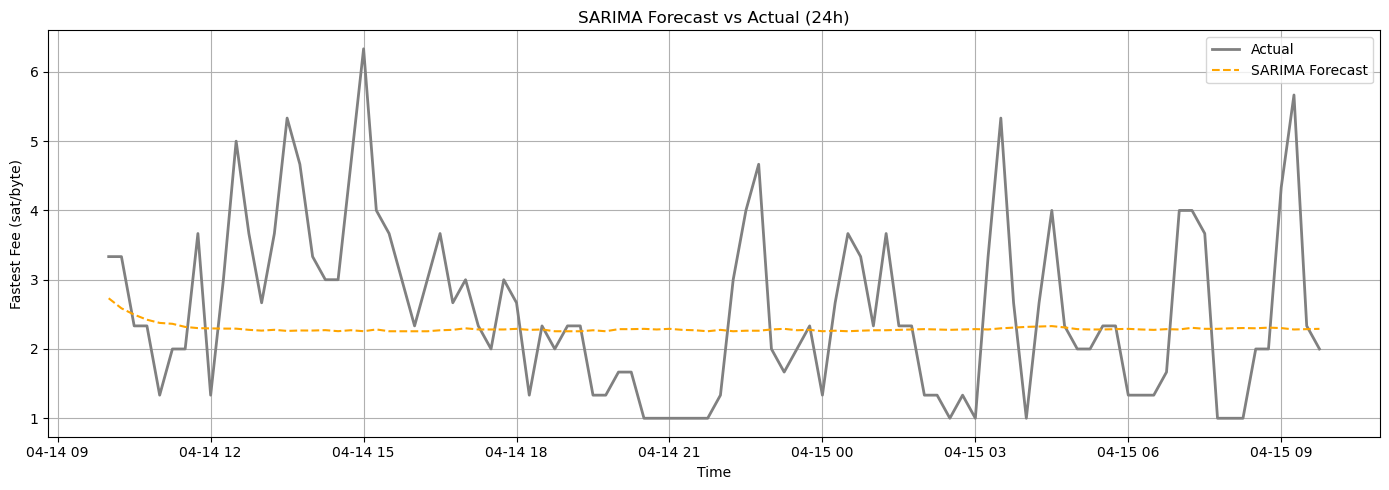

In [11]:
plt.figure(figsize=(14, 5))

plt.plot(y_test.index, y_test.values, label="Actual", color="grey", linewidth=2)
plt.plot(y_test.index, y_pred.values, label="SARIMA Forecast", color="orange", linestyle="--")

plt.title("SARIMA Forecast vs Actual (24h)")
plt.xlabel("Time")
plt.ylabel("Fastest Fee (sat/byte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
